In [7]:
import sys
import os
from os.path import join, abspath, exists
root = abspath(join(os.getcwd(), '../..'))
if root not in sys.path:
    sys.path.append(root)


In [15]:
%load_ext autoreload
%autoreload 2

from riskformer.data.datasets import create_riskformer_dataset
from riskformer.utils.config_utils import load_preprocessing_config, load_train_config
from riskformer.utils.logger_config import logger_setup

# Load configuration files
config_path = join(root, "configs/training/riskformer_config.yaml")
train_config = load_train_config(config_path)
metadata_file = join(root, "resources/riskformer_slide_samples.json")

# Set up logging
logger_setup(
    "notebooks-datasets",
    log_dir=join(root, "logs"),
    debug=False
)

# Create dataset using configuration from riskformer_config.yaml
dataset = create_riskformer_dataset(
    s3_bucket=train_config["s3_bucket"],
    s3_prefix=train_config["s3_prefix"],
    max_dim=train_config["max_dim"],
    overlap=train_config["overlap"],
    metadata_file=metadata_file,
    cache_dir=train_config["cache_dir"],
    config_path=config_path,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1
/home/ec2-user/brca_riskformer/logs


[03/09/25 03:40:00] INFO     Logger already configured, skipping setup.                         ]8;id=8241;file:///home/ec2-user/brca_riskformer/riskformer/utils/logger_config.py\logger_config.py]8;;\:]8;id=213895;file:///home/ec2-user/brca_riskformer/riskformer/utils/logger_config.py#80\80]8;;\

                    INFO     Loading cached SSO token for mgb                                         ]8;id=821518;file:///opt/conda/envs/pytorch/lib/python3.11/site-packages/botocore/tokens.py\tokens.py]8;;\:]8;id=636855;file:///opt/conda/envs/pytorch/lib/python3.11/site-packages/botocore/tokens.py#305\305]8;;\

[03/09/25 03:40:01] INFO     {"event":"load_metadata","status":"success","timestamp":"2025-03- ]8;id=38477;file:///home/ec2-user/brca_riskformer/riskformer/utils/logger_config.py\logger_config.py]8;;\:]8;id=52621;file:///home/ec2-user/brca_riskformer/riskformer/utils/logger_config.py#178\178]8;;\
                             09T03:40:01.179707","total_slides":1099}                                              

                    INFO     {"event":"find_complete_slide_sets","status":"success","timestamp ]8;id=327105;file:///home/ec2-user/brca_riskformer/riskformer/utils/logger_config.py\logger_config.py]8;;\:]8;id=408437;file:///home/ec2-user/brca_riskformer/riskformer/utils/logger_config.py#178\178]8;;\
                             ":"2025-03-09T03:40:01.273716","total_files":208,"total_slides_in                     
                             _metadata":1099,"preprocessed_slides_found":52,"missing_slides":1                     
                             047}                                                                                  

                    INFO     {"event":"create_riskformer_dataset","status":"success","timestam ]8;id=725377;file:///home/ec2-user/brca_riskformer/riskformer/utils/logger_config.py\logger_config.py]8;;\:]8;id=486284;file:///home/ec2-user/brca_riskformer/riskformer/utils/logger_config.py#178\178]8;;\
                             p":"2025-03-09T03:40:01.283088","slide_count":50,"feature_dim":15                     
                             36,"cache_dir":"/tmp/riskformer_cache","include_labels":["odx_tra                     
                             in","odx85","mphr"]}                                                                  

test_data:
Slide ID: <built-in function id>
XL pathces: 94
XL patch size: torch.Size([32, 32, 1536])
	odx_train: tensor([0.9376])


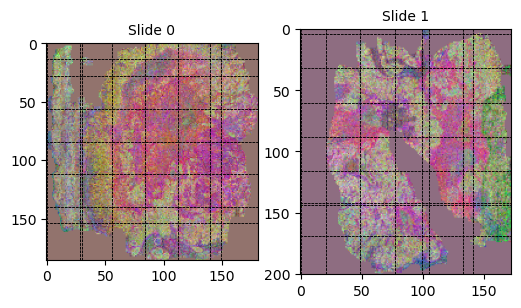

In [17]:
import matplotlib.pyplot as plt
from riskformer.utils.training_utils import rearrange_xl_patches, PatchInfo

xl_patches, metadata = dataset[1]
xl_patch_info = metadata['patch_info']
labels = metadata['labels']
reconstructed_features, idxs = rearrange_xl_patches(
    xl_patches,
    xl_patch_info.cpu().numpy()
)
row_starts, col_starts = idxs
xl_patch_info = PatchInfo.from_tensor_batch(xl_patch_info)

print("test_data:")
print(f"Slide ID: {id}")
print(f"XL pathces: {xl_patches.shape[0]}")
print(f"XL patch size: {xl_patches.shape[1:]}")
for k,v in labels.items():
    print(f"\t{k}: {v}")

n = len(reconstructed_features)
fig_size = 6
f, ax = plt.subplots(1, n, figsize=(fig_size, fig_size * n))
for i, feature in enumerate(reconstructed_features):
    slice = feature.cpu().numpy()
    slice = (slice - slice.min(axis=(0, 1))) / (slice.max(axis=(0, 1)) - slice.min(axis=(0, 1)))
    ax[i].imshow(slice[..., :3])
    # ax[i].axis('off')
    ax[i].set_title(f"Slide {i}", fontsize=10)

    for (feature_id, col_start) in col_starts:
        ax[feature_id].axvline(col_start, color='k', linestyle='--', linewidth=0.5)
    for (feature_id, row_start) in row_starts:
        ax[feature_id].axhline(row_start, color='k', linestyle='--', linewidth=0.5)
plt.show()

torch.Size([74, 5])